In [1]:
! cat ../../.keras/keras.json

{
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "floatx": "float32",
    "image_dim_ordering": "tf"
}

In [2]:
import gc
!python --version

Python 3.5.4


In [3]:
import numpy as np
import cv2
from tqdm import tqdm

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import applications

from sklearn.metrics import fbeta_score
# from sklearn.metrics import matthews_corrcoef, hamming_loss

Using TensorFlow backend.


In [4]:
RESULTS_DIR = "./results/session-01-KagglePlanetAmazon/"
DATA_DIR = "../../Data/kaggle-planet-amazon/"

# !head ../../Data/kaggle-planet-amazon/train_v2.csv

import pandas as pd

df_train = pd.read_csv(DATA_DIR + "train_v2.csv")

# df_train["tags"] = df_train["tags"].map(lambda x: x.split(" "))

df_train.head()

# binarizedLabels_df = pd.DataFrame(binarizedLabels)
# binarizedLabels_df.columns = mlb.classes_
# binarizedLabels_df.head()

df_valid_samples = df_train.sample(frac=0.2)

df_train_samples = df_train.drop(df_valid_samples.index)

def PrintShape(df, df_shape):
    print("{} shape: {}".format(df, df_shape))

PrintShape('df_train_samples', df_train_samples.shape)
PrintShape('df_valid_samples', df_valid_samples.shape)

df_train_samples shape: (32383, 2)
df_valid_samples shape: (8096, 2)


In [11]:
df_valid_pred = df_valid_samples['image_name']
df_valid_pred = df_valid_pred.to_frame()
df_valid_pred.head()

,image_name
17666,train_17666
17096,train_17096
32082,train_32082
34383,train_34383
14657,train_14657


In [5]:
# from sklearn.preprocessing import MultiLabelBinarizer

# mlb = MultiLabelBinarizer()

# y_train = mlb.fit_transform(df_train_samples["tags"])
# y_valid = mlb.fit_transform(df_valid_samples["tags"])

# mlb.classes_

####################################

flatten = lambda l: [item for sublist in l for item in sublist]
labels = list(set(flatten([l.split(' ') for l in df_train['tags'].values])))

label_map = {l: i for i, l in enumerate(labels)}
inv_label_map = {i: l for l, i in label_map.items()}

# Params
input_size = 197
input_channels = 3

epochs = 5
batch_size = 128
learning_rate = 0.001
lr_decay = 1e-4

In [6]:
x_valid = []
y_valid = []

for f, tags in tqdm(df_valid_samples.values, miniters=1000):
    img = cv2.resize(cv2.imread(DATA_DIR + 'train-jpg/{}.jpg'.format(f)), (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_valid.append(img)
    y_valid.append(targets)

y_valid = np.array(y_valid, np.uint8)
x_valid = np.array(x_valid, np.float16)

x_train = []
y_train = []

for f, tags in tqdm(df_train_samples.values, miniters=1000):
    img = cv2.resize(cv2.imread(DATA_DIR + 'train-jpg/{}.jpg'.format(f)), (input_size, input_size))
    targets = np.zeros(17)
    for t in tags.split(' '):
        targets[label_map[t]] = 1
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 1)  # flip horizontally
    x_train.append(img)
    y_train.append(targets)
    img = cv2.flip(img, 0)  # flip vertically
    x_train.append(img)
    y_train.append(targets)

y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float16)

df_test_samples = pd.read_csv(DATA_DIR + 'sample_submission_v2.csv')

x_test = []

for f, tags in tqdm(df_test_samples.values, miniters=1000):
    img = cv2.resize(cv2.imread(DATA_DIR + 'test-jpg/{}.jpg'.format(f)), (input_size, input_size))
    x_test.append(img)

x_test = np.array(x_test, np.float16)

100%|██████████| 61191/61191 [02:03<00:00, 497.17it/s]


In [ ]:
# import pickle

# with open('image_vars.pkl', 'wb') as opfile:
#     pickle.dump(y_valid, opfile, protocol=4)
#     pickle.dump(x_valid, opfile, protocol=4)
#     pickle.dump(y_train, opfile, protocol=4)
#     pickle.dump(x_train, opfile, protocol=4)
#     pickle.dump(x_test, opfile, protocol=4)

# y_valid = []
# x_valid = []
# y_train = []
# x_train = []
# x_test = []

# with open('image_vars.pkl', 'rb') as ipfile:
#     y_valid = pickle.load(ipfile)
#     x_valid = pickle.load(ipfile)
#     y_train = pickle.load(ipfile)
#     x_train = pickle.load(ipfile)
#     x_test = pickle.load(ipfile)

In [7]:
# ResNet50 all but final layer as input to custom model

base_model = applications.resnet50.ResNet50(weights='imagenet', \
                              include_top=False, \
                              input_shape = (input_size, input_size, input_channels))

base_model.summary()

for layer in base_model.layers:
    layer.trainable = False

#Adding custom Layers 
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
# x = Dense(256, activation="relu")(x)
predictions = Dense(17, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=0),
             TensorBoard(log_dir='logs'),
             ModelCheckpoint('resnet50_weights.h5',
                             save_best_only=True)]

opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.fit(x_train,
          y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=2,
          callbacks=callbacks,
          validation_data=(x_valid, y_valid))  # starts training

89505792/94653016 [===========================>..] - ETA: 0s____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 197, 197, 3)   0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 203, 203, 3)   0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 99, 99, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 99, 99, 64)    256         conv1[0][0]                      
_______________________________

Train on 129532 samples, validate on 8096 samples
Epoch 1/5
1171s - loss: 0.1236 - acc: 0.9530 - val_loss: 0.1066 - val_acc: 0.9590
Epoch 2/5
1164s - loss: 0.1089 - acc: 0.9582 - val_loss: 0.1045 - val_acc: 0.9593
Epoch 3/5
1164s - loss: 0.1051 - acc: 0.9595 - val_loss: 0.1018 - val_acc: 0.9605
Epoch 4/5
1163s - loss: 0.1024 - acc: 0.9604 - val_loss: 0.1029 - val_acc: 0.9606
Epoch 5/5
1163s - loss: 0.1001 - acc: 0.9612 - val_loss: 0.1023 - val_acc: 0.9606


In [ ]:
# using functional API
# https://gist.github.com/neka7449/d714fe4ea0f6fa2e560d11d8517d9007

In [ ]:
# using sequential API
# https://gist.github.com/neka7449/f9dac6e0875aeb47b6fac24f7039ce8b

In [9]:
p_valid = model.predict(x_valid, batch_size=batch_size)
print(fbeta_score(y_valid, np.array(p_valid) >= 0.2, beta=2, average='samples'))

y_test = []

p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
y_test.append(p_test)

result = np.array(y_test[0])
result = pd.DataFrame(result, columns=labels)

preds = []

for i in tqdm(range(result.shape[0]), miniters=1000):
    a = result.ix[[i]]
    a = a.apply(lambda x: x >= 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    preds.append(' '.join(list(a.index)))

df_test_samples['tags'] = preds
df_test_samples.to_csv('submission.csv', index=False)

0.910694912179


  0%|          | 0/61191 [00:00<?, ?it/s]/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:15: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
100%|██████████| 61191/61191 [02:19<00:00, 437.19it/s]


In [13]:
y_valid_pred = []

y_valid_pred.append(p_valid)

result_valid = np.array(y_valid_pred[0])
result_valid = pd.DataFrame(result_valid, columns=labels)

valid_preds = []

for i in tqdm(range(result_valid.shape[0]), miniters=1000):
    a = result_valid.ix[[i]]
    a = a.apply(lambda x: x >= 0.2, axis=1)
    a = a.transpose()
    a = a.loc[a[i] == True]
    ' '.join(list(a.index))
    valid_preds.append(' '.join(list(a.index)))

df_valid_pred['tags'] = valid_preds
df_valid_pred.to_csv('valid_submission.csv', index=False)

  0%|          | 0/8096 [00:00<?, ?it/s]/home/ec2-user/src/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
100%|██████████| 8096/8096 [00:18<00:00, 430.22it/s]


  0%|          | 0/10 [00:00<?, ?it/s]

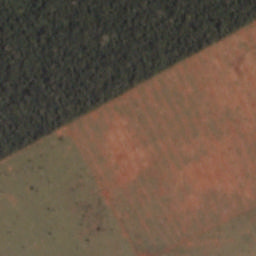

predicted: agriculture clear primary
----------


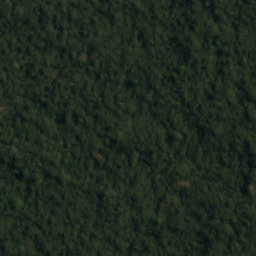

predicted: clear primary
----------


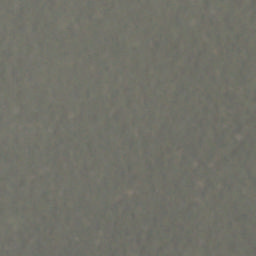

predicted: haze primary
----------


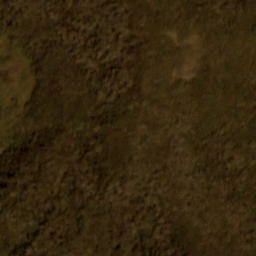

predicted: bare_ground haze primary
----------


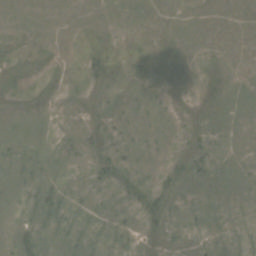

predicted: agriculture clear primary road
----------


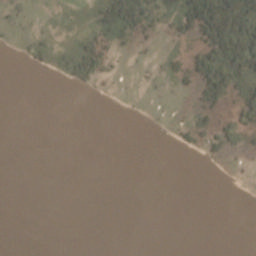

predicted: agriculture clear habitation primary road water
----------


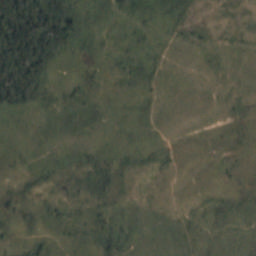

predicted: agriculture clear primary road
----------


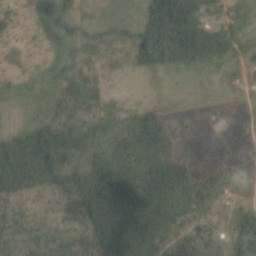

predicted: agriculture clear habitation primary road
----------


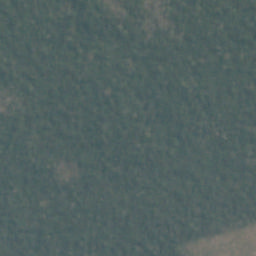

predicted: haze primary
----------


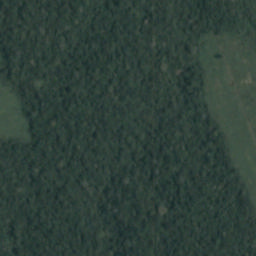

100%|██████████| 10/10 [00:00<00:00, 350.42it/s]

predicted: agriculture clear cultivation primary
----------


In [21]:
from IPython.display import Image, display
submission_samples = pd.read_csv('./submission.csv')
for f, tags in tqdm(df_valid_samples[:10].values, miniters=1000):
    display(Image(filename=DATA_DIR + 'train-jpg/{}.jpg'.format(f)))
    print("actual: "+tags)
    print("----------")

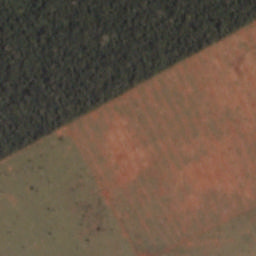

actual: agriculture clear primary
predicted: primary road agriculture clear
----------


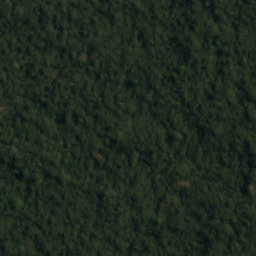

actual: clear primary
predicted: primary clear
----------


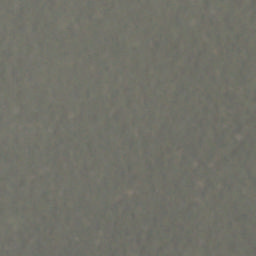

actual: haze primary
predicted: haze primary
----------


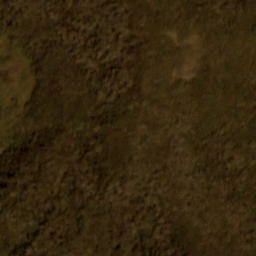

actual: bare_ground haze primary
predicted: primary agriculture clear
----------


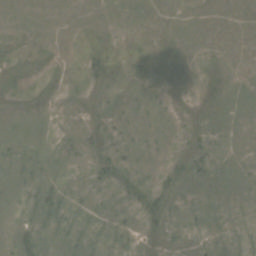

actual: agriculture clear primary road
predicted: haze primary road agriculture clear
----------


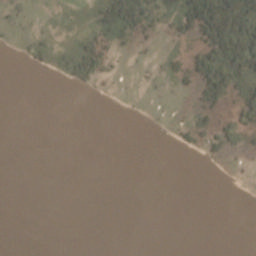

actual: agriculture clear habitation primary road water
predicted: primary road agriculture clear partly_cloudy habitation cultivation water
----------


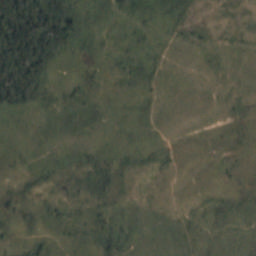

actual: agriculture clear primary road
predicted: primary road agriculture clear
----------


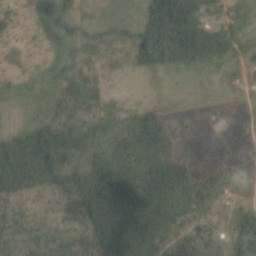

actual: agriculture clear habitation primary road
predicted: primary road agriculture clear partly_cloudy habitation cultivation
----------


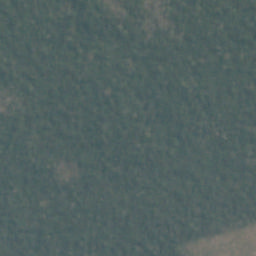

actual: haze primary
predicted: primary agriculture clear cultivation
----------


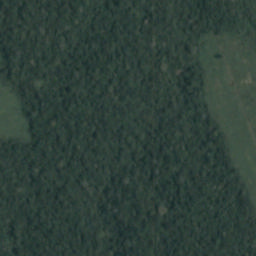

actual: agriculture clear cultivation primary
predicted: primary road agriculture clear habitation cultivation water
----------


In [23]:
from IPython.display import Image, display
submission_samples = pd.read_csv('./submission.csv')
for (f1, tags1),(f2, tags2) in zip(df_valid_samples[:10].values, df_valid_pred[:10].values):
    display(Image(filename=DATA_DIR + 'train-jpg/{}.jpg'.format(f1)))
    print("actual: " + tags1)
    print("predicted: " + tags2)
    print("----------")

In [ ]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

threshold = np.arange(0.1,0.9,0.1)

acc = []
accuracies = []
best_threshold = np.zeros(p_valid.shape[1])
for i in range(p_valid.shape[1]):
    y_prob = np.array(p_valid[:,i])
    for j in threshold:
        y_pred = [1 if prob>=j else 0 for prob in y_prob]
        acc.append(matthews_corrcoef(y_valid[:,i],y_pred))
    acc   = np.array(acc)
    index = np.where(acc==acc.max()) 
    accuracies.append(acc.max()) 
    best_threshold[i] = threshold[index[0][0]]
    acc = []
    
best_threshold

In [ ]:
# best_threshold

# p_test.shape[1]

# y_pred = np.array([[1 if p_test[i,j]>=best_threshold[j] else 0 for j in range(p_test.shape[1])] for i in range(p_test.shape[0])])

# y_pred

# df_test_samples['tags'] = y_pred
# df_test_samples.to_csv('submission.csv', index=False)

# p_valid = model.predict(x_valid, batch_size=batch_size)
# print(fbeta_score(y_valid, np.array(p_valid) >= 0.2, beta=2, average='samples'))

# y_test = []

# p_test = model.predict(x_test, batch_size=batch_size, verbose=2)
# y_test.append(p_test)

# result = np.array(y_test[0])
# result = pd.DataFrame(result, columns=labels)

# preds = []

# for i in tqdm(range(result.shape[0]), miniters=1000):
#     a = result.ix[[i]]
#     a = a.apply(lambda x: x >= 0.3, axis=1)
#     a = a.transpose()
#     a = a.loc[a[i] == True]
#     ' '.join(list(a.index))
#     preds.append(' '.join(list(a.index)))

# df_test_samples['tags'] = preds
# df_test_samples.to_csv('submission.csv', index=False)

# !head submission.csv

# p_valid = model.predict(x_valid, batch_size=batch_size)
# print(fbeta_score(y_valid, np.array(p_valid) >= 0.3, beta=2, average='samples'))

# y_test = np.array(y_test, np.uint8)

# y_test

# p_valid

# p_test

# from sklearn.metrics import matthews_corrcoef
# from sklearn.metrics import hamming_loss

# threshold = np.arange(0.1,0.9,0.1)

# acc = []
# accuracies = []
# best_threshold = np.zeros(p_valid.shape[1])
# for i in range(p_valid.shape[1]):
#     y_prob = np.array(p_valid[:,i])
#     for j in threshold:
#         y_pred = [1 if prob>=j else 0 for prob in y_prob]
#         acc.append(matthews_corrcoef(y_valid[:,i],y_pred))
#     acc   = np.array(acc)
#     index = np.where(acc==acc.max()) 
#     accuracies.append(acc.max()) 
#     best_threshold[i] = threshold[index[0][0]]
#     acc = []

# best_threshold

# print(fbeta_score(y_valid, np.array(p_valid) > 0.4, beta=2, average='samples'))

# len(y_test[0])

# y_pred = np.array([[1 if p_valid[i,j]>=best_threshold[j] else 0 for j in range(y_valid.shape[1])] for i in range(len(y_test[0]))])

# hamming_loss(y_valid,y_pred)

# total_correctly_predicted = len([i for i in range(len(y_valid)) if (y_valid[i]==y_pred[i]).sum() == 17])

# total_correctly_predicted

# x_valid.shape

# (total_correctly_predicted/ x_valid.shape[0]) * 100

In [24]:
gc.collect()

11494